In [34]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import ttest_ind, chi2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

In [2]:
data = pd.read_excel("df_total.xlsx")

<p style = "font_size: 16; color: blue;">欄位選擇</p>

In [3]:
data = data[['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer','AVGX','AVGY','MacNo', 'MacRecipe', 'mtl_desc2', 'vend_nbr',
         'layer_2Thick', 'plate_mtl_desc1', 'plate_mtl_desc2','plate_vend_nbr', 'plate_layer_2Thick', 'plate_RC_value',
         'Residual Copper Rate', 'glass_fabric_thickness(mm)',
         'use_cu_upper_thickness', 'use_cu_lower_thickness', 'use_cu_type',
         'glass_fabric_type', 'short', 'long', 'd_PSVarX', 'd_PSVarY']]

data = data.copy()
data['layer_2Thick'] = data['layer_2Thick'].replace('None', np.nan).astype(float)
data['layer_2Thick'] = data['layer_2Thick'].astype('float')

data['plate_mtl_desc2'] = data['plate_mtl_desc2'].astype('float')

data['plate_layer_2Thick'] = pd.to_numeric(data['plate_layer_2Thick'], errors='coerce')
data = data.rename(columns={"glass_fabric_thickness(mm)": "glass_fabric_thickness_mm"})
data = data.rename(columns={"Residual Copper Rate": "Residual_Copper_Rate"})

<p style = "font_size: 16; color: red;">Full Data</p>

<p style = "font_size: 16; color: blue;">合併少數料號</p>

In [4]:
df = data

# 找出小於閾值的料號列表
part_counts = df['Part_nbr'].value_counts()

threshold = 30
below_threshold_parts = part_counts[part_counts < threshold].index.tolist()

print(f"小於 {threshold} 筆數據的料號共有 {len(below_threshold_parts)} 個：")
# print(below_threshold_parts)

小於 30 筆數據的料號共有 895 個：


In [5]:
# 計算各料號的觀測數
part_counts = df['Part_nbr'].value_counts()

threshold = 30
df['Part_nbr_grouped'] = np.where(df['Part_nbr'].map(part_counts) < threshold,   'OTHER', df['Part_nbr'])

# 按分位數合併（合併底部25%）
# quantile_threshold = part_counts.quantile(0.25)
# df['Part_nbr_grouped'] = np.where(df['Part_nbr'].map(part_counts) < quantile_threshold, 'OTHER', df['Part_nbr'])

<p style = "font_size: 16; color: blue;">Modeling 前處理</p>

<p style = "font_size: 14; color: green;">RC 處理</p>

In [6]:
# 以每個 lot的RC補NaN
l2_rc_map = (
    df[df['d_Layer'] == 'L2']
    .dropna(subset=['plate_RC_value'])
    .groupby('Lot_nbr')['plate_RC_value']
    .first()
)

first_rc_map = (
    df.dropna(subset=['plate_RC_value'])
    .groupby('Lot_nbr')['plate_RC_value']
    .first()
)

final_rc_map = l2_rc_map.combine_first(first_rc_map)

df['plate_RC_value'] = df['plate_RC_value'].fillna(df['Lot_nbr'].map(final_rc_map))

In [7]:
# 剩下的用整體中位數補
overall_median_rc = df['plate_RC_value'].median()

rc_missing_parts = df[df['plate_RC_value'].isna()].groupby('Part_nbr')['plate_RC_value'].count()

all_parts_count = df.groupby('Part_nbr')['plate_RC_value'].count()

rc_missing_parts_aligned = rc_missing_parts.reindex(all_parts_count.index, fill_value=0)

fully_missing_parts = all_parts_count[rc_missing_parts_aligned == all_parts_count].index

df.loc[df['Part_nbr'].isin(fully_missing_parts), 'plate_RC_value'] = overall_median_rc

<p style="font-size: 14px; color: blue;"> 找出遺失值數量(比例)</p>

In [8]:
features_with_na = [features for features in df.columns if df[features].isnull().sum() > 1]

for feature in features_with_na:
    print(feature, df[feature].isnull().sum(), 'missing values')

MacRecipe 182 missing values
layer_2Thick 4990 missing values
plate_layer_2Thick 25282 missing values
glass_fabric_thickness_mm 786 missing values
use_cu_upper_thickness 786 missing values
use_cu_lower_thickness 786 missing values
use_cu_type 1417 missing values
glass_fabric_type 1819 missing values
short 3653 missing values
long 3653 missing values


<p style="font-size: 14px; color: blue;">找出有遺失值的數值型特徵<p>

In [9]:
numerical_features = [feature for feature in df.columns if df[feature].dtypes!='O']

print('Number of features: ',len(numerical_features))

# df[numerical_features].head()

Number of features:  16


<p style="font-size: 14px; color: blue;">找出有遺失值的離散型特徵<p>

In [10]:
discrete_feature = [feature for feature in numerical_features if len(df[feature].unique())<25]
print('Discrete variables count: {}'.format(len(discrete_feature)))
discrete_feature 

Discrete variables count: 3


['MacNo', 'use_cu_upper_thickness', 'use_cu_lower_thickness']

<p style="font-size: 14px; color: blue;">找出有遺失值的類別型特徵<p>

In [11]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print(len(categorical_features))
print(categorical_features)

11
['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'MacRecipe', 'vend_nbr', 'plate_mtl_desc1', 'plate_vend_nbr', 'use_cu_type', 'glass_fabric_type', 'Part_nbr_grouped']


In [12]:
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature, len(df[feature].unique())))

The feature is Part_nbr and number of categories are 1322
The feature is Lot_nbr and number of categories are 4340
The feature is Layer and number of categories are 18
The feature is d_Layer and number of categories are 40
The feature is MacRecipe and number of categories are 205
The feature is vend_nbr and number of categories are 11
The feature is plate_mtl_desc1 and number of categories are 107
The feature is plate_vend_nbr and number of categories are 9
The feature is use_cu_type and number of categories are 44
The feature is glass_fabric_type and number of categories are 86
The feature is Part_nbr_grouped and number of categories are 428


<p style="font-size: 14px; color: blue;">處理離散型遺失值<p>

In [13]:
features_nan = [feature for feature in df.columns if df[feature].isnull().sum()>1 and df[feature].dtype=='O']

for feature in features_nan:
    print('{}: {} missing value'.format(feature, df[feature].isnull().sum()))

MacRecipe: 182 missing value
use_cu_type: 1417 missing value
glass_fabric_type: 1819 missing value


In [14]:
#這裡是將有nan的data挑出來，把nan換成Missing 標籤，因為等等要編碼(encode)，它不能是nan
def replace_cat_feature(data, features_nan):
    data1 = data.copy()
    data1[features_nan]=data[features_nan].fillna('Missing')
    return data1

df = replace_cat_feature(df, features_nan)

#nan沒有了，變成了Missing 標籤，所以都是0
df[features_nan].isnull().sum()

MacRecipe            0
use_cu_type          0
glass_fabric_type    0
dtype: int64

<p style="font-size: 14px; color: blue;">處理數值型遺失值<p>

In [15]:
numerical_with_nan = [feature for feature in df.columns if df[feature].isnull().sum()>1 and df[feature].dtype!='O']

for feature in numerical_with_nan:
    print('{}: {} missing value'.format(feature, df[feature].isnull().sum()))

layer_2Thick: 4990 missing value
plate_layer_2Thick: 25282 missing value
glass_fabric_thickness_mm: 786 missing value
use_cu_upper_thickness: 786 missing value
use_cu_lower_thickness: 786 missing value
short: 3653 missing value
long: 3653 missing value


In [16]:
# 先對每個數值欄位進行分群中位數填補
for feature in numerical_with_nan:
    # 新增一欄標示缺失
    df[feature + '_nan'] = np.where(df[feature].isnull(), 1, 0)
    
    # 對每個 (Part_nbr, Lot_nbr) 群組算中位數來填補
    df[feature] = df.groupby(['Part_nbr', 'Lot_nbr'])[feature]\
                        .transform(lambda x: x.fillna(x.median()))

# 若還有 NaN，用整體中位數補
for feature in numerical_with_nan:
    df[feature] = df[feature].fillna(df[feature].median())


C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.

In [17]:
df[numerical_with_nan].isnull().sum()

layer_2Thick                 0
plate_layer_2Thick           0
glass_fabric_thickness_mm    0
use_cu_upper_thickness       0
use_cu_lower_thickness       0
short                        0
long                         0
dtype: int64

<p style="font-size: 14px; color: blue;">處理類別型遺失值<p>

In [18]:
categorical_feattures = [feature for feature in df.columns if df[feature].dtypes=='O' ]
categorical_feattures

['Part_nbr',
 'Lot_nbr',
 'Layer',
 'd_Layer',
 'MacRecipe',
 'vend_nbr',
 'plate_mtl_desc1',
 'plate_vend_nbr',
 'use_cu_type',
 'glass_fabric_type',
 'Part_nbr_grouped']

In [19]:
# 你想保留的欄位（不處理的）
excluded_features = ['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'Part_nbr_grouped']

# 建立一個新的列表，過濾掉 excluded_features
processed_categorical_features = [f for f in categorical_features if f not in excluded_features]

# rare category 合併
for feature in processed_categorical_features:
    temp = df.groupby(feature)['d_PSVarX'].count() / len(df)
    temp_df = temp[temp > 0.01].index
    df[feature] = np.where(df[feature].isin(temp_df), df[feature], 'rare cate')

# target mean encoding
for feature in processed_categorical_features:
    labels_ordered = df.groupby([feature])['d_PSVarX'].mean().sort_values().index
    labels_ordered = {k: i for i, k in enumerate(labels_ordered, 0)}
    df[feature] = df[feature].map(labels_ordered)

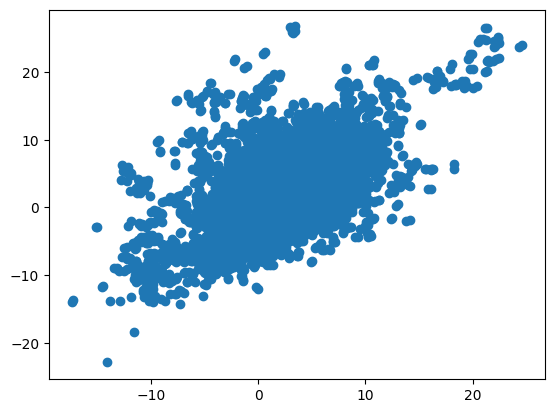

In [20]:
df = df[df['d_PSVarX'] < 4000]
df = df[df['d_PSVarY'] < 4000]
plt.figure(figsize=(10,5))
plt.scatter(df['d_PSVarX'],df['d_PSVarY'])

<p style="font-size: 14px; color: green;">拆分出異常資料<p>

In [29]:
target = 'd_PSVarX'
group_cols = ['Part_nbr', 'Lot_nbr']   # 判定「同一批」用的欄位
group_for_mixed = 'Part_nbr_grouped'           # mixed model 的 groups

df_unfiltered = df

# 使用 group_cols 當作 batch key
df_unfiltered['_batch_key'] = df_unfiltered[group_cols].astype(str).agg('__'.join, axis=1)

batch_stats = df_unfiltered.groupby('_batch_key')[target].agg(['count', 'mean', 'min', 'max']).reset_index()
batch_stats['range'] = batch_stats['max'] - batch_stats['min']

# 規則： range <= 3 且 mean in [0,5] -> normal
batch_stats['is_normal'] = (batch_stats['range'] <= 3) & (batch_stats['mean'] >= 0) & (batch_stats['mean'] <= 5)

# map 回原始 df
batch_flag = batch_stats.set_index('_batch_key')['is_normal'].to_dict()
df_unfiltered['batch_is_normal'] = df_unfiltered['_batch_key'].map(batch_flag)

# 切出 filtered df（只保留正常批）
df_filtered = df_unfiltered[df_unfiltered['batch_is_normal']].copy()
print("原始資料筆數:", len(df_unfiltered), "正常批資料筆數:", len(df_filtered))
print("總批數:", batch_stats.shape[0], "正常批數:", batch_stats['is_normal'].sum())

原始資料筆數: 57169 正常批資料筆數: 30873
總批數: 4339 正常批數: 2579


<p style="font-size: 14px; color: green;">對異常部分的data做GMM<p>

In [30]:
df_outlier = df_unfiltered[~df_unfiltered['batch_is_normal']].copy()

最佳群數: 9


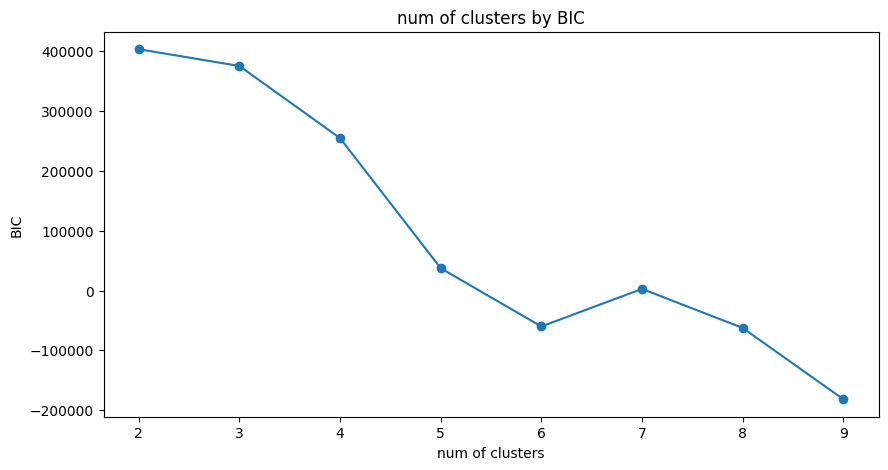

             MacNo  MacRecipe  mtl_desc2  vend_nbr  layer_2Thick  \
cluster                                                            
0         7.995364   6.722792   0.205070  4.011225      7.307994   
1         8.524866   2.359220   0.167453  6.000000      6.051645   
2         9.667012   9.416874   0.165777  4.833610      5.971253   
3         5.075269   8.961290   0.576228  4.965591     18.322516   
4         6.416192   7.086659   0.149363  4.379704      5.550635   
5        13.949735  18.751323   0.186690  5.798942      6.687619   
6         4.443580   3.894942   0.077463  0.715953      5.869416   
7         5.028133   3.764706   0.095386  0.375959      3.750000   
8         4.321267   6.420814   0.194796  4.380090      7.027692   

         plate_mtl_desc1  plate_mtl_desc2  plate_vend_nbr  plate_layer_2Thick  \
cluster                                                                         
0               7.332113         0.095882        3.011225            5.476007   
1       

In [38]:
# 標準化
features = ['MacNo','MacRecipe', 'mtl_desc2', 'vend_nbr', 'layer_2Thick', 'plate_mtl_desc1',
            'plate_mtl_desc2', 'plate_vend_nbr', 'plate_layer_2Thick',
            'plate_RC_value', 'Residual_Copper_Rate', 'glass_fabric_thickness_mm',
            'use_cu_upper_thickness', 'use_cu_lower_thickness', 'use_cu_type',
            'glass_fabric_type']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_outlier[features])

# 用 BIC 選最佳群數
bic_scores = []
n_components_range = range(2, 10)  # 群數範圍
for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))

best_n = n_components_range[np.argmin(bic_scores)]
print(f"num of best clusters: {best_n}")

# 畫 BIC 曲線
plt.figure(figsize=(10,5))
plt.plot(n_components_range, bic_scores, marker='o')
plt.xlabel('num of clusters')
plt.ylabel('BIC')
plt.title('num of best clusters by BIC')
plt.show()

# 用最佳群數建立 GMM
gmm_best = GaussianMixture(n_components=best_n, covariance_type='full', random_state=123)
labels = gmm_best.fit_predict(X_scaled)
df_outlier['cluster'] = labels

# # 用 PCA 降成 2D 繪圖（可視化）
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)
# df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
# df_plot['cluster'] = labels

# plt.figure(figsize=(8,6))
# sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='cluster', palette='Set2')
# plt.title('GMM 分群結果 (PCA 2D 投影)')
# plt.show()

# 檢視各群特徵平均
cluster_means = df_outlier.groupby('cluster')[features].mean()
print(cluster_means)

<p style="font-size: 14px; color: green;">檢查欄位<p>

In [21]:
df = df.copy() 
target = 'd_PSVarX'
group_cols = ['Part_nbr', 'Lot_nbr']   # 判定「同一批」用的欄位
group_for_mixed = 'Part_nbr_grouped'           # mixed model 的 groups
formula = """
d_PSVarX ~ mtl_desc2 + layer_2Thick + plate_mtl_desc2 + plate_layer_2Thick + plate_RC_value +
           Residual_Copper_Rate + glass_fabric_thickness_mm + use_cu_upper_thickness + short + use_cu_lower_thickness +
           C(use_cu_type) + C(glass_fabric_type) + C(vend_nbr) + C(MacRecipe) + C(MacNo)
           """
# -------------------------------------

# 檢查必要欄位存在
for c in group_cols + [target, group_for_mixed]:
    if c not in df.columns:
        raise ValueError(f"資料裡缺少欄位：{c}")

# 轉成數值
# df[target] = pd.to_numeric(df[target], errors='coerce')

<p style = "font_size: 16; color: red;">Filter Data</p>

<p style="font-size: 14px; color: green;">以批號判定正常 / 異常<p>

In [ ]:
df_unfiltered = data

# 使用 group_cols 當作 batch key
df_unfiltered['_batch_key'] = df_unfiltered[group_cols].astype(str).agg('__'.join, axis=1)

batch_stats = df_unfiltered.groupby('_batch_key')[target].agg(['count', 'mean', 'min', 'max']).reset_index()
batch_stats['range'] = batch_stats['max'] - batch_stats['min']

# 規則： range <= 3 且 mean in [0,5] -> normal
batch_stats['is_normal'] = (batch_stats['range'] <= 3) & (batch_stats['mean'] >= 0) & (batch_stats['mean'] <= 5)

# map 回原始 df
batch_flag = batch_stats.set_index('_batch_key')['is_normal'].to_dict()
df_unfiltered['batch_is_normal'] = df_unfiltered['_batch_key'].map(batch_flag)

# 切出 filtered df（只保留正常批）
df_filtered = df_unfiltered[df_unfiltered['batch_is_normal']].copy()
print("原始資料筆數:", len(df), "正常批資料筆數:", len(df_filtered))
print("總批數:", batch_stats.shape[0], "正常批數:", batch_stats['is_normal'].sum())

# 列出不正常的 batch（供檢查）
abnormal_batches = batch_stats[~batch_stats['is_normal']].sort_values(['range','mean'], ascending=[False, True])
abnormal_batches.head(30).to_csv('abnormal_batches_top30.csv', index=False)
print("已輸出 abnormal_batches_top30.csv (供檢查)")

In [ ]:
# 正常批 少量的料號合併
part_counts = df_filtered['Part_nbr'].value_counts()

threshold = 30
df_filtered['Part_nbr_grouped'] = np.where(df_filtered['Part_nbr'].map(part_counts) < threshold,   'OTHER', df_filtered['Part_nbr'])

<p style = "font_size: 14; color: green;">RC 處理</p>

In [ ]:
# 以每個 lot的RC補NaN
l2_rc_map = (
    df_filtered[df_filtered['d_Layer'] == 'L2']
    .dropna(subset=['plate_RC_value'])
    .groupby('Lot_nbr')['plate_RC_value']
    .first()
)

first_rc_map = (
    df_filtered.dropna(subset=['plate_RC_value'])
    .groupby('Lot_nbr')['plate_RC_value']
    .first()
)

final_rc_map = l2_rc_map.combine_first(first_rc_map)

df_filtered['plate_RC_value'] =df_filtered['plate_RC_value'].fillna(df['Lot_nbr'].map(final_rc_map))

In [ ]:
# 剩下的用整體中位數補
overall_median_rc = df_filtered['plate_RC_value'].median()

rc_missing_parts = df_filtered[df_filtered['plate_RC_value'].isna()].groupby('Part_nbr')['plate_RC_value'].count()

all_parts_count = df_filtered.groupby('Part_nbr')['plate_RC_value'].count()

rc_missing_parts_aligned = rc_missing_parts.reindex(all_parts_count.index, fill_value=0)

fully_missing_parts = all_parts_count[rc_missing_parts_aligned == all_parts_count].index

df_filtered.loc[df_filtered['Part_nbr'].isin(fully_missing_parts), 'plate_RC_value'] = overall_median_rc

<p style="font-size: 14px; color: blue;"> 找出遺失值數量(比例)</p>

In [ ]:
features_with_na = [features for features in df_filtered.columns if df_filtered[features].isnull().sum() > 1]

for feature in features_with_na:
    print(feature, df_filtered[feature].isnull().sum(), 'missing values')

<p style="font-size: 14px; color: blue;">找出有遺失值的數值型特徵<p>

In [ ]:
numerical_features = [feature for feature in df_filtered.columns if df_filtered[feature].dtypes!='O']

print('Number of features: ',len(numerical_features))

# df[numerical_features].head()

<p style="font-size: 14px; color: blue;">找出有遺失值的離散型特徵<p>

In [ ]:
discrete_feature = [feature for feature in numerical_features if len(df_filtered[feature].unique())<25]
print('Discrete variables count: {}'.format(len(discrete_feature)))
discrete_feature 

<p style="font-size: 14px; color: blue;">找出有遺失值的類別型特徵<p>

In [ ]:
categorical_features = [feature for feature in df_filtered.columns if df_filtered[feature].dtype == 'O']
print(len(categorical_features))
print(categorical_features)

In [ ]:
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature, len(df_filtered[feature].unique())))

<p style="font-size: 14px; color: blue;">處理離散型遺失值<p>

In [ ]:
features_nan = [feature for feature in df_filtered.columns if df_filtered[feature].isnull().sum()>1 and df_filtered[feature].dtype=='O']

for feature in features_nan:
    print('{}: {} missing value'.format(feature, df_filtered[feature].isnull().sum()))

In [ ]:
#這裡是將有nan的data挑出來，把nan換成Missing 標籤，因為等等要編碼(encode)，它不能是nan
def replace_cat_feature(data, features_nan):
    data1 = data.copy()
    data1[features_nan]=data[features_nan].fillna('Missing')
    return data1

df_filtered = replace_cat_feature(df_filtered, features_nan)

#nan沒有了，變成了Missing 標籤，所以都是0
df_filtered[features_nan].isnull().sum()

<p style="font-size: 14px; color: blue;">處理數值型遺失值<p>

In [ ]:
numerical_with_nan = [feature for feature in df_filtered.columns if df_filtered[feature].isnull().sum()>1 and df_filtered[feature].dtype!='O']

for feature in numerical_with_nan:
    print('{}: {} missing value'.format(feature, df_filtered[feature].isnull().sum()))

In [ ]:
# 先對每個數值欄位進行分群中位數填補
for feature in numerical_with_nan:
    # 新增一欄標示缺失
    df_filtered[feature + '_nan'] = np.where(df_filtered[feature].isnull(), 1, 0)
    
    # 對每個 (Part_nbr, Lot_nbr) 群組算中位數來填補
    df_filtered[feature] = df_filtered.groupby(['Part_nbr', 'Lot_nbr'])[feature]\
                             .transform(lambda x: x.fillna(x.median()))


In [ ]:
print('numbers of NaN in the all lot with df_filtered: \n')
for feature in numerical_with_nan:
    print('{}: {}'.format(feature, df_filtered[feature].isnull().sum()))

In [ ]:
# 若還有 NaN，用整體中位數補
for feature in numerical_with_nan:
    df_filtered[feature] = df_filtered[feature].fillna(df_filtered[feature].median())


In [ ]:
df_filtered[numerical_with_nan].isnull().sum()

<p style="font-size: 14px; color: blue;">處理類別型遺失值<p>

In [ ]:
categorical_feattures = [feature for feature in df_filtered.columns if df_filtered[feature].dtypes=='O' ]
categorical_feattures

In [ ]:
# 你想保留的欄位（不處理的）
excluded_features = ['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'Part_nbr_grouped']

# 建立一個新的列表，過濾掉 excluded_features
processed_categorical_features = [f for f in categorical_features if f not in excluded_features]

# rare category 合併
for feature in processed_categorical_features:
    temp = df_filtered.groupby(feature)['d_PSVarX'].count() / len(df_filtered)
    temp_df = temp[temp > 0.01].index
    df_filtered[feature] = np.where(df_filtered[feature].isin(temp_df), df_filtered[feature], 'rare cate')

# target mean encoding
for feature in processed_categorical_features:
    labels_ordered = df_filtered.groupby([feature])['d_PSVarX'].mean().sort_values().index
    labels_ordered = {k: i for i, k in enumerate(labels_ordered, 0)}
    df_filtered[feature] = df_filtered[feature].map(labels_ordered)

In [ ]:
plt.scatter(df_filtered['d_PSVarX'],df_filtered['d_PSVarY'])

In [ ]:
# 你想保留的欄位（不處理的）
excluded_features = ['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'Part_nbr_grouped']

# 建立一個新的列表，過濾掉 excluded_features
processed_categorical_features = [f for f in categorical_features if f not in excluded_features]

# rare category 合併
for feature in processed_categorical_features:
    temp = df_filtered.groupby(feature)['d_PSVarX'].count() / len(df)
    temp_df = temp[temp > 0.01].index
    df_filtered[feature] = np.where(df_filtered[feature].isin(temp_df), df_filtered[feature], 'rare cate')

# target mean encoding
for feature in processed_categorical_features:
    labels_ordered = df_filtered.groupby([feature])['d_PSVarX'].mean().sort_values().index
    labels_ordered = {k: i for i, k in enumerate(labels_ordered, 0)}
    df_filtered[feature] = df_filtered[feature].map(labels_ordered)

<p style="font-size: 16px; color: blue;">Modeling<p>

<p style="font-size: 14px; color: green;">檢查欄位<p>

In [ ]:
df = df.copy() 
target = 'd_PSVarX'
group_cols = ['Part_nbr', 'Lot_nbr']   # 判定「同一批」用的欄位
group_for_mixed = 'Part_nbr_grouped'           # mixed model 的 groups
formula = """
d_PSVarX ~ mtl_desc2 + layer_2Thick + plate_mtl_desc2 + plate_layer_2Thick + plate_RC_value +
           Residual_Copper_Rate + glass_fabric_thickness_mm + use_cu_upper_thickness + short + use_cu_lower_thickness +
           C(use_cu_type) + C(glass_fabric_type) + C(vend_nbr) + C(MacRecipe) + C(MacNo)
           """
# -------------------------------------

# 檢查必要欄位存在
for c in group_cols + [target, group_for_mixed]:
    if c not in df.columns:
        raise ValueError(f"資料裡缺少欄位：{c}")

# 轉成數值
# df[target] = pd.to_numeric(df[target], errors='coerce')

In [ ]:
df_filtered = df_filtered.copy() 
target = 'd_PSVarX'
group_cols = ['Part_nbr', 'Lot_nbr']   # 判定「同一批」用的欄位
group_for_mixed = 'Part_nbr_grouped'           # mixed model 的 groups
formula = """
d_PSVarX ~ mtl_desc2 + layer_2Thick + plate_mtl_desc2 + plate_layer_2Thick + plate_RC_value +
           Residual_Copper_Rate + glass_fabric_thickness_mm + use_cu_upper_thickness + short + use_cu_lower_thickness +
           C(use_cu_type) + C(glass_fabric_type) + C(vend_nbr) + C(MacRecipe) + C(MacNo)
           """
# -------------------------------------

# 檢查必要欄位存在
for c in group_cols + [target, group_for_mixed]:
    if c not in df.columns:
        raise ValueError(f"資料裡缺少欄位：{c}")

# 轉成數值
# df[target] = pd.to_numeric(df[target], errors='coerce')

In [ ]:
df_filtered[group_for_mixed].value_counts().describe() # check極端小的group

<p style="font-size: 14px; color: green;">定義 fit + diagnostics 函式<p>

In [ ]:
def fit_mixed_and_diagnostics(df_input, label):
    """
    Fit MixedLM with reml=False (for model comparison) and reml=True (final),
    return results dict and draw diagnostics.
    """
    part_counts = df_input['Part_nbr'].value_counts()
    df_input['weights'] = df_input['Part_nbr'].map(lambda x: 1 / part_counts[x])
    
    # fit with ML (reml=False) for fair comparison via AIC/BIC/LLF if needed
    md_ml = smf.mixedlm(formula, df_input, groups=df_input[group_for_mixed], re_formula="1")
    try:
        res_ml = md_ml.fit(reml=False, method='bfgs',  maxiter=2000, weights=df_input["weights"])
    except Exception as e:
        print("[WARN] ML fit failed, try default method. Err:", e)
        res_ml = md_ml.fit(reml=False, weights=df_input["weights"])
    
    # fit final with REML for better variance components
    md_reml = smf.mixedlm(formula, df_input, groups=df_input[group_for_mixed], re_formula="1")
    try:
        res_reml = md_reml.fit(reml=True, method='bfgs', maxiter=2000, weights=df_input["weights"])
    except Exception:
        res_reml = md_reml.fit(reml=True, method='bfgs', weights=df_input["weights"])
    
    # diagnostics
    fitted = res_ml.fittedvalues   # use ML-fitted values for comparability
    resid = res_ml.resid

    out = {
        'label': label,
        'res_ml': res_ml,
        'res_reml': res_reml,
        'fitted': fitted,
        'resid': resid
    }
    return out

In [ ]:
# fit on full and filtered
print("開始 fit 全資料 (ML)... 這可能需要一段時間")
full_mod = fit_mixed_and_diagnostics(df, label='full')


In [ ]:
print("開始 fit 過濾後資料 (ML)...")
filtered_mod = fit_mixed_and_diagnostics(df_filtered, label='filtered')

<p style="font-size: 14px; color: green;">比較模型指標<p>

In [ ]:
def print_compare(full, filtered):
    print("===== ML (reml=False) 比較 =====")
    print("Full:  llf=%.3f   AIC=%.3f   BIC=%.3f   nobs=%d" % (full['res_ml'].llf, full['res_ml'].aic, full['res_ml'].bic, full['res_ml'].nobs))
    print("Filt:  llf=%.3f   AIC=%.3f   BIC=%.3f   nobs=%d" % (filtered['res_ml'].llf, filtered['res_ml'].aic, filtered['res_ml'].bic, filtered['res_ml'].nobs))
    print("\n===== REML (final estimates) 摘要 (filtered) =====")
    print(full['res_reml'].summary())
    print(filtered['res_reml'].summary())
    
print_compare(full_mod, filtered_mod)

In [ ]:
import numpy as np

group_for_mixed = 'Part_nbr_grouped'           # mixed model 的 groups
formula = """
d_PSVarX ~ mtl_desc2 + layer_2Thick + plate_mtl_desc2 + plate_layer_2Thick + plate_RC_value +
           Residual_Copper_Rate + glass_fabric_thickness_mm + use_cu_upper_thickness + short + use_cu_lower_thickness +
           C(use_cu_type) + C(glass_fabric_type) + C(vend_nbr) + C(MacRecipe) + C(MacNo)
           """

n_boot = 500
coef_results = []

for i in range(n_boot):
    boot_df = df_filtered.groupby('Part_nbr_grouped', group_keys=False).apply(lambda x: x.sample(frac=1, replace=True))
    boot_model = smf.mixedlm(formula, boot_df, groups=boot_df["Part_nbr_grouped"])
    boot_result = boot_model.fit()
    coef_results.append(boot_result.params)

coef_df = pd.DataFrame(coef_results)
print(coef_df)  # 看係數分佈


In [ ]:
coef_df.describe().to_excel('coef_df_BT500.xlsx', index=False)

In [ ]:
# LRT for df_filtered
#    use_cu_type: O
#    glass_fabric_type: O
#    vend_nbr: O
#    MacRecipe: O
#    MacNo: O

formula1 = """
d_PSVarX ~ mtl_desc2 + layer_2Thick + plate_mtl_desc2 + plate_layer_2Thick + plate_RC_value +
           Residual_Copper_Rate + glass_fabric_thickness_mm + use_cu_upper_thickness + short + use_cu_lower_thickness +
           C(use_cu_type) + C(glass_fabric_type) + C(vend_nbr) + C(MacRecipe) + C(MacNo)
           """
full = smf.mixedlm(formula1, df_filtered, groups=df_filtered[group_for_mixed], re_formula="1").fit(reml=False, method='bfgs', maxiter=2000)

formula2 = """
d_PSVarX ~ mtl_desc2 + layer_2Thick + plate_mtl_desc2 + plate_layer_2Thick + plate_RC_value +
           Residual_Copper_Rate + glass_fabric_thickness_mm + use_cu_upper_thickness + short + use_cu_lower_thickness +
           C(use_cu_type) + C(glass_fabric_type) + C(vend_nbr) + C(MacRecipe) + C(MacNo)
           """
reduced = smf.mixedlm(formula2, df_filtered, groups=df_filtered[group_for_mixed], re_formula="1").fit(reml=False, method='bfgs', maxiter=2000)

# df_diff = (len(full.params) - len(reduced.params))
df_diff = full.fe_params.size - reduced.fe_params.size   # 使用 fixed-effects 參數數量差

lr_stat = 2 * (full.llf - reduced.llf) 
p_value = chi2.sf(lr_stat, df=df_diff) 

print(f"Likelihood Ratio Test Results:")
print(f"LR Statistic: {lr_stat:.4f}")
print(f"Degrees of Freedom: {df_diff}")
print(f"p-value: {p_value:.4g}")

In [ ]:
md_reml = smf.mixedlm(formula, df_filtered, groups=df_filtered[group_for_mixed], re_formula="1")
mdf = md_reml.fit()
re = mdf.cov_re

with warnings.catch_warnings():
    # Parameter is often on the boundary
    warnings.simplefilter("ignore")
    likev = mdf.profile_re(0, "re", dist_low=0.1 , dist_high=0.1)

plt.figure(figsize=(10, 8))
plt.plot(likev[:, 0], 2 * likev[:, 1])
plt.xlabel("Variance of random slope", size=17)
lbl = plt.ylabel("-2 times profile log likelihood", size=17)

<p style="font-size: 14px; color: green;">畫殘差診斷圖 (QQ + Fitted vs Residuals)<p>

In [ ]:
def plot_diagnostics(res_obj, fitted, resid, title_prefix):
    # 創建一個新的圖形，設置大小
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    
    # 第一個子圖：QQ圖
    sm.qqplot(resid, line='45', fit=True, ax=ax1)
    ax1.set_title(f'{title_prefix} QQ plot')

    # 第二個子圖：殘差圖
    ax2.scatter(fitted + np.random.normal(0, 1e-6, size=len(fitted)), resid, alpha=0.5, s=10)
    ax2.axhline(0, color='red', linestyle='--')
    ax2.set_xlabel('Fitted values (jittered)')
    ax2.set_ylabel('Residuals')
    ax2.set_title(f'{title_prefix} Residuals vs Fitted')
    
    plt.tight_layout()
    plt.show()

print("Diagnostics: Full model")
plot_diagnostics(full_mod['res_ml'], full_mod['fitted'], full_mod['resid'], 'Full')

print("Diagnostics: Filtered model")
plot_diagnostics(filtered_mod['res_ml'], filtered_mod['fitted'], filtered_mod['resid'], 'Filtered')

In [ ]:
durbin_watson(filtered_mod['resid']) # 獨立ok

<p style="font-size: 14px; color: green;">ICC（群內相關係數） —> 直觀看 group variance 比例<p>

In [ ]:
np.corrcoef(data['short'], data['d_PSVarX'])

In [59]:
md_full_reml = smf.mixedlm(formula, df, groups=df['Part_nbr_grouped'], re_formula="1")
res_full_reml = md_full_reml.fit(reml=True, method='bfgs', maxiter=2000)

md_filtered_reml = smf.mixedlm(formula, df_filtered, groups=df_filtered['Part_nbr_grouped'], re_formula="1")
res_filtered_reml = md_filtered_reml.fit(reml=True, method='bfgs', maxiter=2000)

def compute_icc(res, verbose=False):
    """
    從 statsmodels MixedLMResults 物件取出 group variance (cov_re) 與 residual variance (scale),
    並計算 ICC = group_var / (group_var + resid_var).
    支援 cov_re 為 DataFrame / ndarray / Series，及 >1 隨機效果的情形 (使用 trace).
    """
    # 1) 取得 cov_re，轉成 ndarray
    cov_re = getattr(res, 'cov_re', None)
    if cov_re is None:
        raise ValueError("res 物件沒有 cov_re 屬性。請確認 res 是 mixedlm 的 fit 結果。")

    # 將可能的 pandas 結構轉為 numpy array
    if isinstance(cov_re, pd.DataFrame) or isinstance(cov_re, pd.Series):
        cov_arr = cov_re.values
    else:
        cov_arr = np.asarray(cov_re)

    # 2) 決定 group variance 的計算方式
    # 若是 1x1，直接取 scalar；否則取 trace（總變異）
    if cov_arr.size == 1:
        group_var = float(cov_arr.ravel()[0])
    else:
        # 若 cov_arr 非方陣，嘗試取方陣部分；一般 cov_re 應為方陣
        if cov_arr.shape[0] != cov_arr.shape[1]:
            if verbose:
                print("警告：cov_re 不是方陣，shape =", cov_arr.shape)
            # 退而求其次：取對角和
            group_var = float(np.diag(cov_arr).sum())
        else:
            group_var = float(np.trace(cov_arr))

    # 3) 取得 residual variance
    resid_var = float(getattr(res, 'scale', np.nan))

    # 4) 數值穩定處理：如果出現負值(理論上不應該)，將其夾到 0
    if np.isnan(group_var) or np.isinf(group_var):
        raise ValueError("group_var 為 NaN 或 infinite，請檢查 fit 結果。")
    if group_var < 0:
        if verbose:
            print(f"注意：group_var = {group_var} < 0，將其設為 0.")
        group_var = 0.0
    if resid_var < 0:
        if verbose:
            print(f"注意：resid_var = {resid_var} < 0，將其設為 0.")
        resid_var = 0.0

    # 5) 計算 ICC（若分母為 0 則回傳 NaN）
    denom = group_var + resid_var
    icc = group_var / denom if denom > 0 else np.nan

    if verbose:
        print("cov_re type:", type(cov_re), "cov_re shape:", getattr(cov_re, 'shape', cov_arr.shape))
        print("group_var:", group_var, "resid_var:", resid_var, "ICC:", icc)

    return group_var, resid_var, icc


gvar_full, rvar_full, icc_full = compute_icc(res_full_reml, verbose=True)
gvar_filt, rvar_filt, icc_filt = compute_icc(res_filtered_reml, verbose=True)

print("FULL  -> group_var: {:.4f}, resid_var: {:.4f}, ICC: {:.3f}".format(gvar_full, rvar_full, icc_full))
print("FILTER-> group_var: {:.4f}, resid_var: {:.4f}, ICC: {:.3f}".format(gvar_filt, rvar_filt, icc_filt))

# ICC 就是「隨機效果總變異 / (總變異 + 殘差變異)」

# ICC 越高代表 Part_nbr 之間的差異相對於總變異越大（群間影響大）；ICC 低則群內變異占比高。

# 比較 full vs filtered 的 ICC，可以看出你過濾掉的資料佔了多少 between/within variation（你之前的數字顯示過濾後 both 減小）。


cov_re type: <class 'pandas.core.frame.DataFrame'> cov_re shape: (1, 1)
group_var: 3.4809863818861886 resid_var: 4.148979396807464 ICC: 0.4562256873558584
cov_re type: <class 'pandas.core.frame.DataFrame'> cov_re shape: (1, 1)
group_var: 0.5890200532523655 resid_var: 1.2066664446114417 ICC: 0.32801942541366674
FULL  -> group_var: 3.4810, resid_var: 4.1490, ICC: 0.456
FILTER-> group_var: 0.5890, resid_var: 1.2067, ICC: 0.328


<p style="font-size: 14px; color: green;">特徵之間的相關性與共線性（VIF）<p>

In [63]:
X = df_filtered[['MacNo','MacRecipe', 'mtl_desc2', 'vend_nbr', 'layer_2Thick', 'plate_mtl_desc1',
                'plate_mtl_desc2', 'plate_vend_nbr', 'plate_layer_2Thick',
                'plate_RC_value', 'Residual_Copper_Rate', 'glass_fabric_thickness_mm',
                'use_cu_upper_thickness', 'use_cu_lower_thickness', 'use_cu_type',
                'glass_fabric_type', 'short']]

np.linalg.matrix_rank(X), X.shape[1]

(np.int64(17), 17)

In [80]:
import patsy
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 建 design matrix for fixed-effects only
formula = """
d_PSVarX ~ layer_2Thick + plate_mtl_desc2 + plate_layer_2Thick + plate_RC_value +
           Residual_Copper_Rate + glass_fabric_thickness_mm + use_cu_upper_thickness + short + use_cu_lower_thickness
           """

design_info = smf.mixedlm(formula, df_filtered, groups=df_filtered[group_for_mixed]).fit_regularized(method='l1', alpha=1.0, reml=False).model.data.design_info
X = patsy.build_design_matrices([design_info], df_filtered)[0]
X_df = pd.DataFrame(X, columns = design_info.column_names)

# VIF (略去 intercept if present)
vif_data = pd.DataFrame()
vif_data["feature"] = X_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
print(vif_data.sort_values('VIF', ascending=False).head(30))


                     feature           VIF
0                  Intercept  15697.729066
1               layer_2Thick      4.345370
6  glass_fabric_thickness_mm      4.051314
9     use_cu_lower_thickness      2.165260
7     use_cu_upper_thickness      2.163096
5       Residual_Copper_Rate      1.124484
3         plate_layer_2Thick      1.064836
4             plate_RC_value      1.034185
2            plate_mtl_desc2      1.014997
8                      short      1.005008


In [110]:
import pandas as pd
from patsy import dmatrix
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. 用 patsy 根據你的 formula 建立 design matrix（包含所有 dummy）
design_info = smf.mixedlm(formula, df_filtered, groups=df_filtered[group_for_mixed]).fit_regularized(method='l1', alpha=1.0, reml=False).model.data.design_info
X = patsy.build_design_matrices([design_info], df_filtered)[0]
X_df = pd.DataFrame(X, columns=design_info.column_names)

# 2. 找出哪些欄位是同一組 categorical dummy，例如 prefix 相同
#    這裡示範以你的 categorical_cols 舉例，匹配 dummy 欄位名稱開頭

grouped_dummies = {}
for cat in categorical_cols:
    grouped_dummies[cat] = [col for col in X_df.columns if col.startswith(f"C({cat})")]

# 3. 對每組 dummy 用 PCA 取第一主成分，替代該組全部 dummy
pca_features = []
for cat, cols in grouped_dummies.items():
    if len(cols) > 1:
        pca = PCA(n_components=1)
        pc1 = pca.fit_transform(X_df[cols])
        pca_features.append(pd.Series(pc1.flatten(), name=f"PCA_{cat}"))
    else:
        # 只有一個dummy，直接用該欄位
        pca_features.append(X_df[cols[0]])

# 4. 保留數值變數原始欄位 (不含 categorical dummy 的部分)
non_cat_cols = [col for col in X_df.columns if all(not col.startswith(f"C({cat})") for cat in categorical_cols)]

# 5. 合併 PCA 轉換後的特徵和非類別特徵
X_reduced = pd.concat([X_df[non_cat_cols]] + pca_features, axis=1)

# 6. 計算 VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_reduced.columns
vif_data["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]

print(vif_data.sort_values('VIF', ascending=False))


                      feature           VIF
0                   Intercept  15723.340460
1                layer_2Thick      4.359911
6   glass_fabric_thickness_mm      4.086056
9      use_cu_lower_thickness      2.211590
7      use_cu_upper_thickness      2.210201
10            PCA_use_cu_type      1.349348
4              plate_RC_value      1.165263
11      PCA_glass_fabric_type      1.158675
5        Residual_Copper_Rate      1.133034
3          plate_layer_2Thick      1.085770
12               PCA_vend_nbr      1.080450
13              PCA_MacRecipe      1.074952
14                  PCA_MacNo      1.043238
2             plate_mtl_desc2      1.025071
8                       short      1.005521


In [112]:
explained_var_ratio = pca.explained_variance_ratio_[0]
print(f"PC1 explained variance ratio: {explained_var_ratio:.4f}")

PC1 explained variance ratio: 0.3234


In [75]:
# requirements:
# pip install scikit-learn statsmodels pandas numpy patsy

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
import patsy
import warnings

warnings.filterwarnings("ignore")

# ------------------------
# 1) 建構設計矩陣函式
# ------------------------
def build_design_matrix(df, numeric_cols, categorical_cols, drop_first=True, handle_unknown='ignore'):
    """
    回傳 X (ndarray) 與 X_df (DataFrame with column names)
    - numeric_cols: list of numeric column names
    - categorical_cols: list of categorical column names
    - drop_first: whether to drop first dummy to avoid perfect multicollinearity
    """
    # ColumnTransformer with OneHotEncoder for categoricals
    ohe = OneHotEncoder(drop='first' if drop_first else None,
                        sparse_output=False, handle_unknown=handle_unknown)
    transformers = []
    if categorical_cols:
        transformers.append(('cat', ohe, categorical_cols))
    if numeric_cols:
        transformers.append(('num', 'passthrough', numeric_cols))
    ct = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0)
    X_arr = ct.fit_transform(df)

    # build column names
    col_names = []
    if categorical_cols:
        cat_names = ct.named_transformers_['cat'].get_feature_names_out(categorical_cols)
        col_names.extend(list(cat_names))
    if numeric_cols:
        col_names.extend(numeric_cols)

    X_df = pd.DataFrame(X_arr, columns=col_names, index=df.index)
    return X_arr, X_df, ct

# ------------------------
# 2) 條件數（condition number）
# ------------------------
def condition_number(X, scaled=True):
    """
    計算 condition number = s_max / s_min (SVD singular values)
    若 scaled=True, 會先把 X 每 column 做標準化 (zero mean, unit var)
    """
    Xc = np.array(X, dtype=float)
    if scaled:
        Xc = (Xc - np.nanmean(Xc, axis=0)) / (np.nanstd(Xc, axis=0) + 1e-12)
    # SVD
    s = np.linalg.svd(Xc, compute_uv=False)
    # guard small singular values
    cond = float(s[0] / (s[-1] + 1e-20))
    return cond, s

# ------------------------
# 3) VIF 計算（只建議對數值或有限數量的 dummy）
# ------------------------
def compute_vif(X_df):
    """
    計算 VIF for each column in X_df. X_df should be a pandas DataFrame.
    Warning: VIF for many dummies may be noisy.
    """
    X = X_df.copy().astype(float)
    # add const to avoid singular design for VIF calc
    X['__const__'] = 1.0
    vif_vals = []
    cols = X.columns.tolist()
    for i, col in enumerate(cols[:-1]):  # skip const at the end
        try:
            vif = variance_inflation_factor(X.values, i)
        except Exception:
            vif = np.nan
        vif_vals.append((col, vif))
    return pd.DataFrame(vif_vals, columns=['feature', 'VIF']).sort_values('VIF', ascending=False)

# ------------------------
# 4) LassoCV pipeline fitting
# ------------------------
def fit_lasso_cv(X_df, y, n_alphas=100, cv=5, random_state=42):
    """
    Fit LassoCV and standardize features. Return fitted pipeline and report sparsity.
    """
    scaler = StandardScaler()
    lasso_cv = LassoCV(cv=cv, n_alphas=n_alphas, random_state=random_state, max_iter=2000)
    # Standardize X first
    Xs = scaler.fit_transform(X_df.values)
    lasso_cv.fit(Xs, y.values)
    alpha_opt = lasso_cv.alpha_
    coef = lasso_cv.coef_
    nonzero_idx = np.nonzero(coef)[0]
    nonzero_features = X_df.columns[nonzero_idx].tolist()
    sparsity = 1.0 - (len(nonzero_idx) / X_df.shape[1])
    report = {
        'alpha_opt': alpha_opt,
        'n_features': X_df.shape[1],
        'n_nonzero': len(nonzero_idx),
        'sparsity': sparsity,
        'nonzero_features': nonzero_features,
        'coef': pd.Series(coef, index=X_df.columns)
    }
    return lasso_cv, scaler, report

# ------------------------
# 5) Lasso 穩定性選擇 (bootstrap frequency)
# ------------------------
def lasso_stability_selection(X_df, y, n_boot=100, sample_frac=0.75, alpha=None, cv=3, random_state=0):
    """
    Repeated Lasso fits on bootstrap samples: return selection frequency for each feature.
    If alpha is None, use LassoCV on each bootstrap sample; otherwise use fixed alpha.
    """
    rng = np.random.RandomState(random_state)
    n = X_df.shape[0]
    sel_counts = np.zeros(X_df.shape[1], dtype=int)
    for i in range(n_boot):
        idx = rng.choice(n, size=int(sample_frac * n), replace=True)
        Xs = X_df.values[idx]
        ys = y.values[idx]
        scaler = StandardScaler()
        Xs = scaler.fit_transform(Xs)
        if alpha is None:
            model = LassoCV(cv=cv, random_state=rng.randint(1e6), max_iter=2000).fit(Xs, ys)
            alpha_i = model.alpha_
            lasso = Lasso(alpha=alpha_i, max_iter=2000).fit(Xs, ys)
        else:
            lasso = Lasso(alpha=alpha, max_iter=2000).fit(Xs, ys)
        sel_counts += (np.abs(lasso.coef_) > 1e-8).astype(int)
    freq = sel_counts / float(n_boot)
    return pd.Series(freq, index=X_df.columns).sort_values(ascending=False)

# ------------------------
# 6) 一個整合流程函式
# ------------------------
def collinearity_l1_diagnostics(df, target, numeric_cols, categorical_cols,
                                 do_vif=True, vif_limit_report=30, lasso_cv=True,
                                 stability_boot=100):
    """
    一鍵執行：建立設計矩陣、計算 condition number、(可選)VIF、LassoCV、以及穩定性測試
    回傳一個 dict 包含結果與 dataframe summary
    """
    # build design matrix
    X_arr, X_df, ct = build_design_matrix(df, numeric_cols, categorical_cols, drop_first=True)
    # drop columns with zero variance
    nz_mask = (X_df.std(axis=0) > 1e-12)
    if not nz_mask.all():
        X_df = X_df.loc[:, nz_mask]

    # compute condition number
    cond, svals = condition_number(X_df.values, scaled=True)

    out = {'X_df': X_df, 'condition_number': cond, 'singular_values': svals}

    # optionally compute VIF (warning: expensive for many cols)
    if do_vif:
        # if too many columns, skip or apply to top-k numeric/dummy
        if X_df.shape[1] > 300:
            out['vif'] = None
            out['vif_note'] = f"Too many features ({X_df.shape[1]}), skip full VIF. Consider subset VIF on numeric or top-k dummies."
        else:
            out['vif'] = compute_vif(X_df)
    # LassoCV fit
    if lasso_cv:
        y = df[target]
        lasso_model, scaler, lasso_report = fit_lasso_cv(X_df, y, cv=5)
        out['lasso_report'] = lasso_report
        # model performance on full data (just for quick check)
        Xs_full = scaler.transform(X_df.values)
        out['lasso_r2'] = lasso_model.score(Xs_full, y.values)
    # stability selection
    if stability_boot and lasso_cv:
        alpha_use = out['lasso_report']['alpha_opt']
        freq = lasso_stability_selection(X_df, df[target], n_boot=stability_boot, alpha=alpha_use)
        out['selection_freq'] = freq
    return out

In [87]:
df.columns

Index(['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'AVGX', 'AVGY', 'MacNo',
       'MacRecipe', 'mtl_desc2', 'vend_nbr', 'layer_2Thick', 'plate_mtl_desc1',
       'plate_mtl_desc2', 'plate_vend_nbr', 'plate_layer_2Thick',
       'plate_RC_value', 'Residual_Copper_Rate', 'glass_fabric_thickness_mm',
       'use_cu_upper_thickness', 'use_cu_lower_thickness', 'use_cu_type',
       'glass_fabric_type', 'short', 'long', 'd_PSVarX', 'd_PSVarY',
       'Part_nbr_grouped', 'layer_2Thick_nan', 'plate_layer_2Thick_nan',
       'glass_fabric_thickness_mm_nan', 'use_cu_upper_thickness_nan',
       'use_cu_lower_thickness_nan', 'short_nan', 'long_nan'],
      dtype='object')

In [93]:
# ------------------------
# Example usage:
# ------------------------
# 假設 df 是你的 dataframe, target 為 'd_PSVarX'
# numeric_cols = ['mtl_desc2', 'layer_2Thick', 'plate_mtl_desc2', 'plate_layer_2Thick', 'plate_RC_value', 'Residual_Copper_Rate', 
#                 'glass_fabric_thickness_mm', 'use_cu_upper_thickness', 'use_cu_lower_thickness', 'short']
numeric_cols = [ 'layer_2Thick', 'plate_mtl_desc2', 'plate_layer_2Thick', 'plate_RC_value', 'Residual_Copper_Rate', 
                 'glass_fabric_thickness_mm', 'use_cu_upper_thickness', 'use_cu_lower_thickness', 'short']

categorical_cols = ['use_cu_type', 'glass_fabric_type', 'vend_nbr', 'MacRecipe', 'MacNo']
res = collinearity_l1_diagnostics(df_filtered, target='d_PSVarX', numeric_cols=numeric_cols, categorical_cols = [],
                                  do_vif=False, lasso_cv=True, stability_boot=100)

# then:
print("Condition number:", res['condition_number'])
print("Lasso alpha", res['lasso_report']['alpha_opt'])
print("Nonzero features:", res['lasso_report']['n_nonzero'])
print("Top selection freq:\n", res['selection_freq'].head(30))


Condition number: 4.167106256625314
Lasso alpha 0.004913598113621431
Nonzero features: 6
Top selection freq:
 Residual_Copper_Rate         1.00
short                        1.00
plate_RC_value               1.00
glass_fabric_thickness_mm    1.00
use_cu_lower_thickness       0.98
plate_mtl_desc2              0.92
plate_layer_2Thick           0.59
layer_2Thick                 0.34
use_cu_upper_thickness       0.30
dtype: float64


In [94]:
def weighted_mean_encoding(df, cat_col, target, weight_col=None):
    if weight_col is None:
        # 權重為1（等權）
        weight_col = '__w__'
        df[weight_col] = 1

    weighted_means = (
        df.groupby(cat_col)
          .apply(lambda g: (g[target] * g[weight_col]).sum() / g[weight_col].sum())
          .to_dict()
    )

    return df[cat_col].map(weighted_means)

# 建立新 DataFrame 做 encoding
df_encoded = df_filtered.copy()

# 用加權平均編碼 categorical_cols
for col in categorical_cols:
    df_encoded[col] = weighted_mean_encoding(
        df_encoded, 
        cat_col=col, 
        target='d_PSVarX', 
        weight_col=None  # 如果有特定權重欄位可以換掉
    )

# 再跑 collinearity_l1_diagnostics
numeric_cols_extended = numeric_cols + categorical_cols  # 因為編碼後都是數字
res = collinearity_l1_diagnostics(
    df_encoded, 
    target='d_PSVarX', 
    numeric_cols=numeric_cols_extended, 
    categorical_cols=[],  # 已經轉成數值
    do_vif=False, 
    lasso_cv=True, 
    stability_boot=100
)

print("Condition number:", res['condition_number'])
print("Lasso alpha", res['lasso_report']['alpha_opt'])
print("Nonzero features:", res['lasso_report']['n_nonzero'])
print("Top selection freq:\n", res['selection_freq'].head(30))


Condition number: 4.360634556334792
Lasso alpha 0.022245169629053967
Nonzero features: 7
Top selection freq:
 Residual_Copper_Rate         1.00
MacRecipe                    1.00
MacNo                        1.00
glass_fabric_type            1.00
vend_nbr                     0.80
glass_fabric_thickness_mm    0.70
use_cu_lower_thickness       0.53
short                        0.37
plate_RC_value               0.21
plate_layer_2Thick           0.05
plate_mtl_desc2              0.04
use_cu_type                  0.01
layer_2Thick                 0.00
use_cu_upper_thickness       0.00
dtype: float64


<p style="font-size: 14px; color: green;">找出對殘差貢獻最大的 Part_nbr / Lot_nbr<p>